# Estimación de un modelo del lenguaje (bigramas)

Para crear un modelo del lenguaje $\mu=(\Sigma,A,\Pi)$, indexaremos las palabras del corpus de entrenamiento a partir de número. En el vocabulario guardaremos la palabra y el índice numérico respectivo. Para esto, definimos las siguientes dos funciones:

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from itertools import chain
import pandas as pd

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

### Preprocesamiento de los datos

Para el modelo del lenguaje, asumiremos un corpus de entrenamiento muy simple. En este caso, creamos el vocabulario 'idx' e indexamos cada símbolo del vocabulario.

In [26]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'el perro', 'un gato come croquetas']

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(cads_idx)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [0, 1], [3, 10, 2, 11]]


Podemos ver que el vocabulario es un diccionario donde se asocian los símbolos y sus índices numéricos.

In [27]:
print(idx)

defaultdict(<function vocab.<locals>.<lambda> at 0x7f5f98c09790>, {'el': 0, 'perro': 1, 'come': 2, 'un': 3, 'hueso': 4, 'muchacho': 5, 'jugaba': 6, 'saltaba': 7, 'la': 8, 'cuerda': 9, 'gato': 10, 'croquetas': 11})


Ahora debemos indicar el inicio y el fin de cada cadena. Para esto, utilizaremos las estiquetas BOS (Beginning Of Sentence) y EOS (End Of Sentence).

In [28]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(idx.values())+2
EOS_IDX = max(idx.values())+1

#Se agregan estas etiqeutas al vocabulario
idx[EOS] = EOS_IDX
idx[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in cads_idx]

print(cadenas)

[[13, 0, 1, 2, 3, 4, 12], [13, 3, 5, 6, 12], [13, 0, 5, 7, 8, 9, 12], [13, 0, 1, 12], [13, 3, 10, 2, 11, 12]]


Ahora creamos los bigramas a partir de las cadenas de entrenamiento. En este caso, incluimos bigramas del tipo ($<BOS>$,$w_0$) y ($w_T$,$<EOS>$) que nos serán útiles para construir el modelo. Asimismo, obtenemos las frecuencias.

In [29]:
#Se crean los bigramas
bigrams = list(chain(*[zip(cad,cad[1:]) for cad in cadenas]))

#Se obtiene la frecuencia de cada bigrama
frecBigrams = Counter(bigrams)

print(bigrams)

[(13, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 12), (13, 3), (3, 5), (5, 6), (6, 12), (13, 0), (0, 5), (5, 7), (7, 8), (8, 9), (9, 12), (13, 0), (0, 1), (1, 12), (13, 3), (3, 10), (10, 2), (2, 11), (11, 12)]


### Estimación del modelo

Obtenemos el número de elementos que hay en el vocabulario y creamos la matriz de transiciones $A$ y el vector de probabilidades iniciales $\Pi$.

In [30]:
#Numero de tipos sin contar las etiqeutas BOS y EOS
N = len(idx)-2

#La matriz A es de NxN+1, los renglones consideran EOS
A = np.zeros((N,N+1))

#Pi es de tamano N
Pi = np.zeros(N)

Procedemos a llenar la matriz $A$ y el vector $\Pi$ con las frecuencias de bigramas. Para la matriz de transiciones, tenemos que:

$$A = (a_{ij}) = fr([w_i,w_j])$$

Se considera a la etiqueta EOS en los finales de cadenas. Para el vector de iniciales tenemos que:

$$\Pi = (\pi_i) = fr([<BOS>,w_i])$$

In [31]:
for bigram,frec in frecBigrams.items():
    if bigram[0] != BOS_IDX:
        A[bigram[0],bigram[1]] = frec
    elif bigram[0] == BOS_IDX:
        Pi[bigram[1]] = frec

En este caso, el modelo sólo cuenta con frecuencias. Falta obtener las probabilidades.

In [33]:
pd.DataFrame(data=A.T, columns=list(idx.keys())[:-2], index=list(idx.keys())[:-1])

,el,perro,come,un,hueso,muchacho,jugaba,saltaba,la,cuerda,gato,croquetas
el,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perro,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
come,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
un,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hueso,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
muchacho,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jugaba,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
saltaba,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
la,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
cuerda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
pd.DataFrame(data=A.T/A.sum(1), columns=list(idx.keys())[:-2], index=list(idx.keys())[:-1])

,el,perro,come,un,hueso,muchacho,jugaba,saltaba,la,cuerda,gato,croquetas
el,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perro,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
come,0.000000,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
un,0.000000,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hueso,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
muchacho,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jugaba,0.000000,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
saltaba,0.000000,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
la,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
cuerda,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Usaremos un estimador Lidstone, que definiremos como:

$$p_{lid}(w_j|w_i) = \frac{fr([w_i,w_j]) + \lambda}{\sum_k fr([w_i,w_k]) + \lambda N}$$

In [36]:
#Definicion de estimador Lidstone
def get_model_Lid(frec_trans, frec_init, l=0.0):
    #Añadir parámetro
    addA = frec_trans + l
    addPi = frec_init + l
    
    #Obtener probabilidades de transición
    mu_A = addA.T/addA.sum(1)
    #Obtener probabilidades de inicio
    mu_Pi = addPi/addPi.sum(0)
    
    return (mu_A.T,mu_Pi)

Definida la función así, podemos estimar la probabilidad de los datos a partir de variar el parámetro $\lambda$. En primer lugar, podemos obtener la probabilidad frecuentista (que llamaremos MLE) dada por:

$$p_{mle}(w_j|w_i) = \frac{fr([w_i,w_j])}{\sum_k fr([w_i,w_k])}$$

En este caso, $\lambda =0$.

In [44]:
#Se obtienen las probabilidades
A_mle, Pi_mle = get_model_Lid(A,Pi,l=0)

pd.DataFrame(data=A_mle.T, columns=list(idx.keys())[:-2], index=list(idx.keys())[:-1])

,el,perro,come,un,hueso,muchacho,jugaba,saltaba,la,cuerda,gato,croquetas
el,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perro,0.666667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
come,0.000000,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
un,0.000000,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hueso,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
muchacho,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jugaba,0.000000,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
saltaba,0.000000,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
la,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
cuerda,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Podemos comprobar que nuestro estimador es una probabilidad, para esto vemos que la matriz de transiciones cumple:

$$\sum_{j=1}^{N+1} (a_{ij}) = 1$$

(En este caso, hemos tomado en cuenta al símbolo de término EOS). Y el vector de probabilidades iniciales cumple:

$$\sum_{i=1}^{N} \pi_i = 1$$

In [38]:
print(A_mle.sum(1))
print(Pi_mle.sum(0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


In [40]:
A_mle[idx['el'],idx['perro']]

0.6666666666666666

Ahora que tenemos nuestro modelo $\mu$, podemos obtener la probabilidad de cadenas. Para esto definimos una función dada por:

$$p(w_0 ... w_T) = \pi_0 \prod_{i=2}^T p(w_i|w_{i-1})$$

In [41]:
def prob_cad(cad,mu):
    #Matrices del modelo
    A_mu, Pi_mu = mu
    #Obtenemos los simbolos
    seq = cad.split()
    #Obtenemos los bigramas de la cadena de evaluacion
    bigrSeq = zip(seq,seq[1:])
    
    #Guardamos la probabilidad inicial dado el modelo
    p = Pi_mu[idx[seq[0]]]
    #Multiplicamos por las probabilidades de los bigramas dado el modelo
    for gram1,gram2 in bigrSeq:
        p *= A_mu[idx[gram1],idx[gram2]]
    
    return p  

Podemos, entonces, probar como es que este modelo del lenguaje estima las probabilidades de dos cadenas: una contenida en los datos; y otra agramatical.

In [42]:
#Cadenas de prueba
str1 = 'el perro come croquetas'
str2 = 'un perro come un hueso'

print('\t--Probabilidad MLE--')
print( str1,': \t', prob_cad(str1,(A_mle,Pi_mle)) )
print( str2,': \t', prob_cad(str2,(A_mle,Pi_mle)) )

	--Probabilidad MLE--
el perro come croquetas : 	 0.09999999999999999
un perro come un hueso : 	 0.0


## Smoothing

De igual forma, podemos utilizar una probabilidad laplaciana para definir el modelo. En este caso, utilizaremos la función de probabilidad dada por:


$$p_{lap}(w_j|w_i) = \frac{fr([w_i,w_j]) + 1}{\sum_k fr([w_i,w_k]) + N}$$

Es decir, tomaremos $\lambda = 1$.

In [53]:
#Modelo con probabilidad laplaciana
A_lap, Pi_lap = get_model_Lid(A,Pi,l=1)

#Comprobar que suman 1
print(A_lap.sum(1))
print(Pi_lap.sum(0))
pd.DataFrame(data=A_lap.T, columns=list(idx.keys())[:-2], index=list(idx.keys())[:-1])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0


,el,perro,come,un,hueso,muchacho,jugaba,saltaba,la,cuerda,gato,croquetas
el,0.0625,0.066667,0.066667,0.0625,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
perro,0.1875,0.066667,0.066667,0.0625,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
come,0.0625,0.133333,0.066667,0.0625,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.142857,0.071429
un,0.0625,0.066667,0.133333,0.0625,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
hueso,0.0625,0.066667,0.066667,0.1250,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
muchacho,0.1250,0.066667,0.066667,0.1250,0.071429,0.066667,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
jugaba,0.0625,0.066667,0.066667,0.0625,0.071429,0.133333,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
saltaba,0.0625,0.066667,0.066667,0.0625,0.071429,0.133333,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
la,0.0625,0.066667,0.066667,0.0625,0.071429,0.066667,0.071429,0.142857,0.071429,0.071429,0.071429,0.071429
cuerda,0.0625,0.066667,0.066667,0.0625,0.071429,0.066667,0.071429,0.071429,0.142857,0.071429,0.071429,0.071429


Y podemos comparar las probabilidades que se obtienen con este estimador:

In [54]:
print('\t--Probabilidad Laplaciana--')
print( str1,': \t', prob_cad(str1,(A_lap,Pi_lap)) )
print( str2,': \t', prob_cad(str2,(A_lap,Pi_lap)) )

	--Probabilidad Laplaciana--
el perro come croquetas : 	 0.0007843137254901959
un perro come un hueso : 	 2.4509803921568626e-05


Como puede observarse, al tomar la probabilidad Laplaciana, las transiciones que no se vieron en el corpus tienen una probabilidad diferente de 0, pero que es baja. Esto es una ventaja, pues podemos asignar probabilidades a transiciones no atestiguadas, asignándoles baja probabilidad de transición.

### Generación de cadenas

Una vez establecido el modelo del lenguaje, éste puede utilizarse en diferentes aplicaciones de NLP. Los modelos del lenguaje, en general están presentes en un gran número de tareas (traducción automática, reconocimiento de voz, reconocimiento óptico de caracteres, etc.). Una de sus aplicaciones más inmediatas es el autocompletado. Esto es, predecir la palabra $\hat{w}$ más probable dada una cadena $w_1,...,w_{i-1}$ de palabras anteriores. Para determinar esta predicción, buscamos:

$$\hat{w} = \arg\max_{w} p(w_1 w_2...w_{n-1} w)$$

Esta probabilidad se puede determinar a partir del modelo $\mu$ que hemos definido de la forma siguiente:

$$\hat{w} = \arg\max_{w} p(w|w_{n-1})p(w_1 w_2...w_{n-1})$$

In [51]:
#Diccionario para recuperar palabras a partir de sus índices
get_word = {i:w for w,i in idx.items()}

def next_word(string, mu):
    #Elementos del modelo
    A, Pi = mu
    #Obtener la probabilidad de la historia
    p_prev = prob_cad(string, mu)
    #Obtener la última palabra en la historia
    last_w = string.split()[-1]
    #Obtener el argumento que maximiza la probabilidad
    max_w = np.argmax(A[idx[last_w]]*p_prev)
    
    return get_word[max_w], A[idx[last_w],max_w]
    
pred, prob_pred = next_word('el perro',(A_lap,Pi_lap))
print('Palabra siguiente más probable: "{}" con  probabilidad: {}'.format(pred, prob_pred))

Palabra siguiente más probable: "come" con  probabilidad: 0.47417840375586856


Si aplicamos esta predicción d eforma iterativa, podemos, además, producir texto a partir de una cadena de entrada. Para esto, buscaremos encontrar la cadena con mayor probabilidad dado una estimulo de entrada. Este proceso acabará cuando la palabra siguiente con mayor probabilidad sea EOS (End Of String).

In [52]:
def generate(string, mu):
    #Guarda la palabra predicha
    w = ''
    #Guarda la cadena que se ha generado
    str_gen = string
    #El método se detiene al ver <EOS>
    while w != '<EOS>':
        #Predice la siguiente palabra
        w, p = next_word(str_gen, mu)
        #Agrega esa palabra a ala cadena
        str_gen += ' ' + w
    
    #Regresa la cadena si el símbolo EOS
    return str_gen[:len(str_gen)-6]
    
print(generate('el', (A_lap,Pi_lap) ))

el perro come un hueso


### Evaluación del modelo del lenguaje

Para tener una idea de que tan bueno es el modelo que estimamos, podemos utilizar la entropía cruzada empírica dada por la función:

$$H_E(p) = -\frac{1}{M} \sum_{x_1,...,x_m}^N \log p(x_1, ...x_m)$$

En este caso, el modelo con menor entropía será aquel que mejor prediga una (o varias) cadenas no vistas. Por tanto, consideraremos que generaliza mejor. De aquí, que busquemos un modelo que minimice esta función.

En otros casos, se utiliza la perplejidad, la cual se define en base a esta entropía como $2^{H_E(p)}$.

In [20]:
#Corpus para evaluar el modelo (cadenas no vistas)
eval_corp = ['el perro jugaba un hueso','el muchacho jugaba la cuerda', 'un muchacho come un hueso']

def H(mu):
    #Entropía
    H = 0.0
    for cad in eval_corp:
        #Probabilidad de la cadena
        p_cad = prob_cad(cad,mu)
        #Número de bigramas
        M = len(cad.split())
        #Obtenemos la entropía cruzada de la cadena
        H -= np.log(p_cad)/M       
    
    return H/len(eval_corp)

In [21]:
print( 'Entropía, modelo MLE: \t', H((A_mle,Pi_mle)) )
print( 'Entropía, modelo Laplaciano\t:', H((A_lap,Pi_lap)) )

Entropía, modelo MLE: 	 inf
Entropía, modelo Laplaciano	: 2.126066556461792


<ipython-input-20-427d63191c84>:13: RuntimeWarning: divide by zero encountered in log
  H -= np.log(p_cad)/M


El modelo de frecuentista (MLE) es incapaz de asignarle una probabilidad distinta de 0 a cadenas que nunca vio; por tanto, no es capaz de generalizar adecuadamente. En este sentido, la probabilidad con smoothing laplaciano resulta ser un mejor estimador.

Pero ¿cuál sería el mejor estimador que podríamos obtener? Si nos enfocamos a la familia de estimadores de Lidstone, basta variar el parámetro $\lambda$ y determinar cuándo se minimiza la entropía cruzada. Para esto, tomamos varios valores de $\lambda$ (desde 0.01 hasta 2) y observamos cómo se comporta la entropía cruzada.

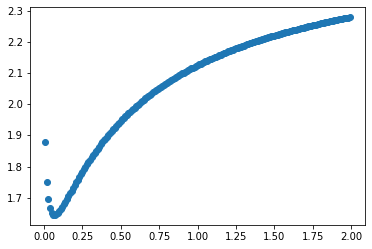

In [22]:
#Guarda valores de entropía
rank_H = []
for i in range(1,200):
    #rango de 0.01 a 2
    k = float(i)/100
    #obtiene los valores de entropia
    rank_H.append( (k,H(get_model_Lid(A,Pi,l=k))) )

#Visualización
rank_H = np.array(rank_H)
plt.scatter(rank_H[:,0],rank_H[:,1])
plt.show()

Así, podemos obtener el valor de $\lambda$ que minimice la entropía y estimar una distribución de probabilidad Lidstone con este parámetro.

In [23]:
#Parámetro que minimiza entropía
l_min = rank_H[:,0][np.argmin(rank_H[:,1])]
print(l_min)

#Estimación de probabilidad
A_lid, Pi_lid = get_model_Lid(A,Pi,l=l_min)

0.07


Y al igual que hicimos con los otros estimadores, podemos determinar la probabilidad de cadenas.

In [24]:
print('\t--Probabilidad Lidstone--')
print( str1,': \t', prob_cad(str1,(A_lid,Pi_lid)) )
print( str2, ': \t', prob_cad(str2,(A_lid,Pi_lid)) )

	--Probabilidad Lidstone--
el perro come croquetas : 	 0.03239343265848567
un perro come un hueso : 	 0.0004316129690761788


Finalmente, es posible combinar funciones de probabilidad a partir de la interpolación, dada por:

$$p_{int}(w_j|w_i) = \sum_i \lambda_i \cdot p_i(w_j|w_i)$$

Recordando que $\sum_i \lambda_i =1$.

In [25]:
#Interpolación
l1, l2, l3 = 0.3, 0.1, 0.6
A_int = l1*A_lid + l2*A_lap + l3*A_mle
Pi_int = l1*Pi_lid + l2*Pi_lap + l3*Pi_mle

print('\t--Probabilidad Interpolación')
print( str1,': \t', prob_cad(str1,(A_int, Pi_int)) )
print( str2, ': \t', prob_cad(str2,(A_int, Pi_int)) )

print( '\nEntropía de la interpolación:', H((A_int, Pi_int)) )

	--Probabilidad Interpolación
el perro come croquetas : 	 0.06277132123679298
un perro come un hueso : 	 0.0005072568251760231

Entropía de la interpolación: 1.7379299563197428
